# 1. Data exploration

In [959]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import it_core_news_sm
from nltk.corpus import stopwords as sw
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier


dev_set = pd.read_csv(filepath_or_buffer="C:\\Users\\Administrator\\Desktop\\DATA LAB\\PROJECT_ASSIGNMENT\\dataset_winter_2020\\development.csv",  sep=',')
eva_set = pd.read_csv(filepath_or_buffer="C:\\Users\\Administrator\\Desktop\\DATA LAB\\PROJECT_ASSIGNMENT\\dataset_winter_2020\\evaluation.csv",  sep=',')

## 1.1 Set exploration and missing values detection

In [960]:
dev_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28754 entries, 0 to 28753
Data columns (total 2 columns):
text     28754 non-null object
class    28754 non-null object
dtypes: object(2)
memory usage: 449.4+ KB


In [961]:
dev_set.isnull().values.any()

False

## 1.2 Statistics

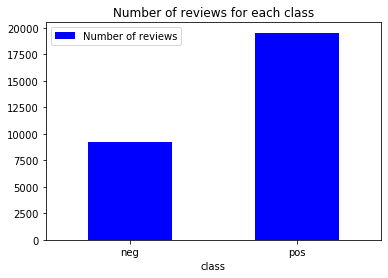

In [962]:
ax = dev_set.groupby('class').count().plot.bar(color='blue', title='Number of reviews for each class', rot=0)
ax.legend(['Number of reviews'])

In [963]:
def words_counter(df):
    counter = 0
    for t in word_tokenize(df):
        counter += 1
    return counter

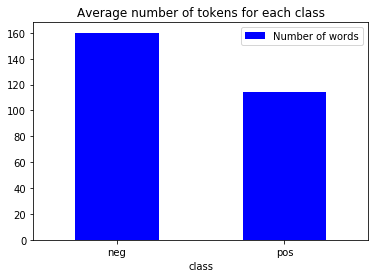

In [964]:
dev_set['Number of words'] = dev_set['text'].apply(words_counter)
dev_set.groupby('class').mean().plot.bar(color='blue', title='Average number of tokens for each class',rot=0)

## 1.2 Wordclouds

In [965]:
from wordcloud import WordCloud

it_stopwords = sw.words('italian')

def to_string(pos_reviews, neg_reviews):
    p_wordcloud = ""
    n_wordcloud = ""
    for p in pos_reviews:
        p_wordcloud += p + " "
    for n in neg_reviews:
        n_wordcloud += n + " "
    return p_wordcloud, n_wordcloud

def plot_wordcloud(string, max_words):
    wc = WordCloud(width=600, height=300, background_color="white", stopwords=it_stopwords, max_words=60)
    p = wc.generate(string)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(p, interpolation='bilinear')
    ax.axis("off")

In [966]:
p_mask = (dev_set['class'] == 'pos')
n_mask = (dev_set['class'] == 'neg')

pos_dev = dev_set.loc[p_mask, 'text']
neg_dev = dev_set.loc[n_mask, 'text']

In [967]:
pos_string, neg_string = to_string(pos_dev, neg_dev)

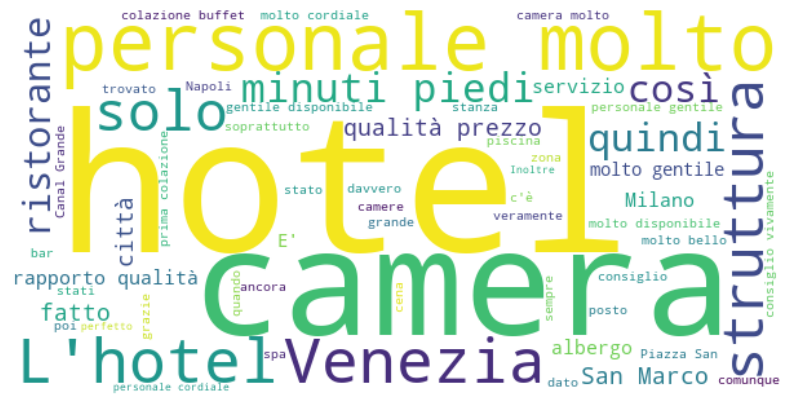

In [968]:
plot_wordcloud(pos_string, 60)

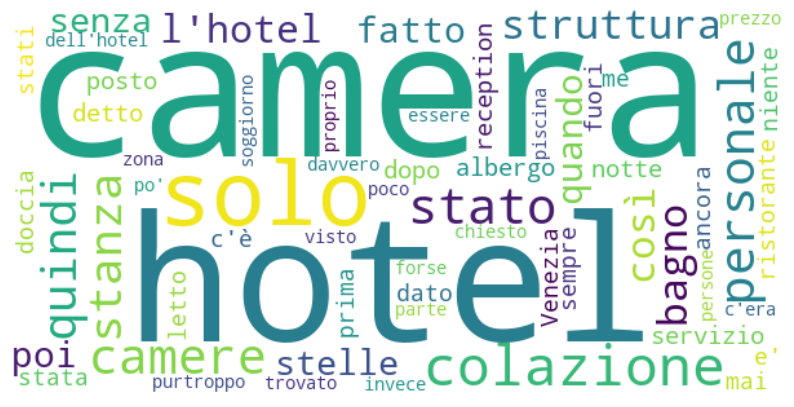

In [969]:
plot_wordcloud(neg_string, 60)

# 2. Preprocessing

## 2.1 Filtering

In [970]:
it_stopwords = sw.words('italian')
punctuations = ["''",'--','!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',','-', '.', '/', ':', ';',
                '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
it_stopwords.remove('non')
it_stopwords.remove('ma')
all_stopwords = it_stopwords + ['hotel', 'camera', 'albergo', 'colazione','posizione','stanza','personale','reception',
                                'struttura','strutturare','ristorante','ristorare','essere','avere','fare','stare','potere','dovere','soggiornare','trovare','così',
                                 'quando','roma','firenze','venezia','napoli','milano']

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def filtering(df):
    filtered_df = ""
    for t in word_tokenize(df):
        t = t.lower()
        if (t == 'ma'):
            filtered_df += t + " "
        if (len(t) > 2) and (t.isdigit() == False) and (t not in punctuations) and (t not in it_stopwords):
            filtered_df += t + " "
    return filtered_df

## 2.2 Lemmatizing

In [971]:
lemmatizer = it_core_news_sm.load(disable=['parser', 'tagger', 'ner'])

def lemmatizing(df):
    lemmatized = ""
    for t in lemmatizer(df):
        if (t.lemma_ not in all_stopwords) and (not hasNumbers(t.lemma_)):
            lemmatized += t.lemma_ + " "
    return lemmatized

dev_set['filtered'] = dev_set['text'].apply(filtering)
dev_set['lemmatized'] = dev_set['filtered'].apply(lemmatizing)
eva_set['filtered'] = eva_set['text'].apply(filtering)
eva_set['lemmatized'] = eva_set['filtered'].apply(lemmatizing)

## 2.3 WordClouds after lemmatization

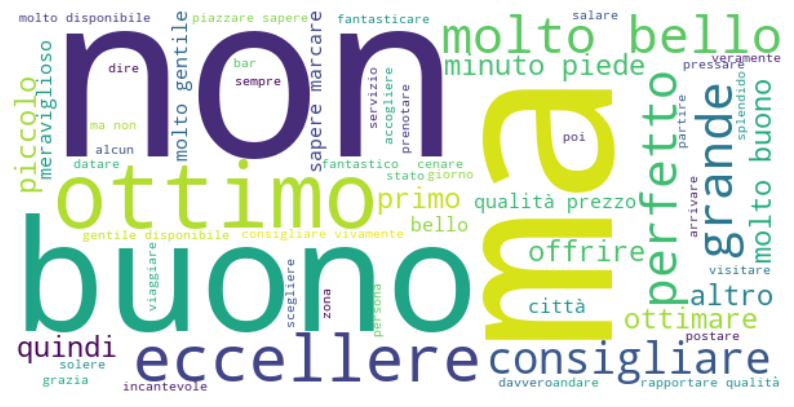

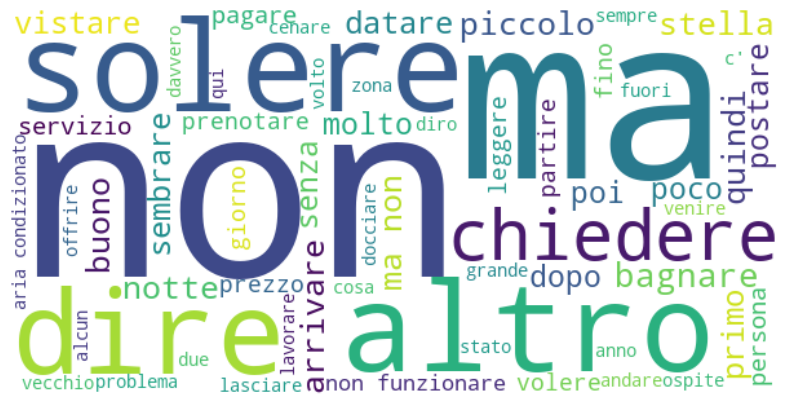

In [972]:
pos_lemm = dev_set.loc[p_mask,'lemmatized']
neg_lemm = dev_set.loc[n_mask,'lemmatized']
pos_lemm_string, neg_lemm_string = to_string(pos_lemm, neg_lemm)
plot_wordcloud(pos_lemm_string, 150)
plot_wordcloud(neg_lemm_string, 150)

## 2.4 Tf-Idf vectorizer

In [973]:
vectorizer = TfidfVectorizer(stop_words=all_stopwords, min_df=2, ngram_range = (1,2))
X_train = vectorizer.fit_transform(dev_set['lemmatized'])
X_test = vectorizer.transform(eva_set['lemmatized'])

y_train = dev_set['class']
X_train.shape, X_test.shape

((28754, 187502), (12323, 187502))

In [974]:
def get_frequency(word):
    pos_vectorizer = TfidfVectorizer(stop_words=all_stopwords, min_df=2, ngram_range = (1,2))
    neg_vectorizer = TfidfVectorizer(stop_words=all_stopwords, min_df=2, ngram_range = (1,2))
    X_dev_pos = pos_vectorizer.fit_transform(pos_lemm)
    X_dev_neg = neg_vectorizer.fit_transform(neg_lemm)
    X_dev_pos[X_dev_pos > 0] = 1
    X_dev_neg[X_dev_neg > 0] = 1
    df_pos = pd.DataFrame.sparse.from_spmatrix(X_dev_pos, columns=pos_vectorizer.get_feature_names())
    df_neg = pd.DataFrame.sparse.from_spmatrix(X_dev_neg, columns=neg_vectorizer.get_feature_names())
    freq = (df_neg[word].value_counts()[1] + df_pos[word].value_counts()[1])/(len(df_pos)+len(df_neg))
    return freq

# 3. Algorithm choice

## 3.1 X_train 2D representation 

Total variance explained: 0.004692935225999704


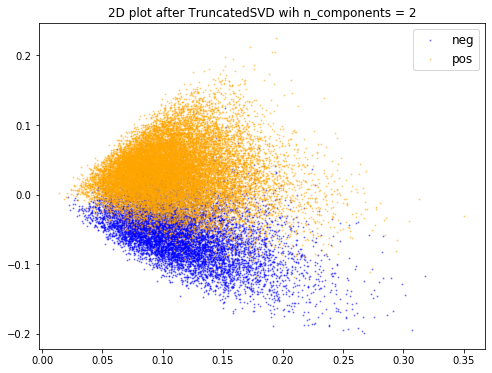

In [975]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = pd.DataFrame(svd.fit_transform(X_train))
pos_indexes = dev_set[dev_set['class']=='pos'].index
neg_indexes = dev_set[dev_set['class']=='neg'].index

X_svd_pos = X_svd.loc[pos_indexes]
X_svd_neg = X_svd.loc[neg_indexes]

fig, ax = plt.subplots(figsize=(8, 6))
plt.title('2D plot after TruncatedSVD wih n_components = 2')
ax.scatter(X_svd_neg[0], X_svd_neg[1], s=1, color='blue', alpha=0.4, label='neg')
ax.scatter(X_svd_pos[0], X_svd_pos[1], s=1, color='orange', alpha=0.4, label='pos')
plt.legend(loc='upper right', fontsize=12)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):}")

# 4. Tuning and validation

## 4.1 GridSearch with Cross-validation

In [979]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearSVC

def binarize(s):
    y=[]
    for i in s:
        if i=='pos':
            y.append(1)
        else: y.append(0)
    return np.array(y)

clf = LinearSVC()
X = X_train
y = binarize(dev_set['class'])

params = {'C': [1,10,100], 'class_weight':['balanced', None]}
clf = GridSearchCV(clf, params, cv=10, scoring='f1')
clf.fit(X, y)

print("Best parameters set found on development set:")
print(clf.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))

ImportError: cannot import name 'LinearSVC' from 'sklearn.linear_model' (c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\__init__.py)

## 4.2 Classification report

              precision    recall  f1-score   support

         neg     0.9504    0.9498    0.9501      2827
         pos     0.9755    0.9759    0.9757      5800

    accuracy                         0.9673      8627
   macro avg     0.9630    0.9628    0.9629      8627
weighted avg     0.9673    0.9673    0.9673      8627



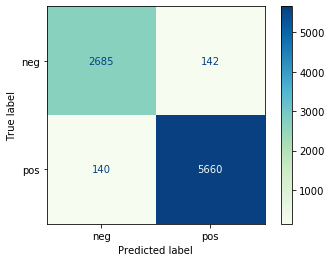

In [980]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

X = X_train
y = binarize(dev_set['class'])
CX_train, CX_test, Cy_train, Cy_test = train_test_split(X, y, train_size = 0.7, random_state = 42, shuffle = True)
svc = LinearSVC(class_weight='balanced')
classifier = svc.fit(CX_train, Cy_train)
Cy_pred = svc.predict(CX_test)

print(classification_report(Cy_test, Cy_pred, target_names=['neg','pos'], digits = 4))
plot_confusion_matrix(classifier, CX_test, Cy_test, display_labels=['neg','pos'], cmap='GnBu', values_format='.4g')

## 4.3 Most informative features

	-3.7509	non            		3.3008	ottimare       
	-3.4502	cattivo        		3.2987	eccellere      
	-3.1786	scarso         		3.1755	perfetto       
	-3.0189	non tornare    		3.1687	ottimo         
	-2.8756	sporco         		2.6603	confortevole   
	-2.7668	non consigliare		2.5442	consigliare    
	-2.6672	vecchio        		2.3392	spazioso       
	-2.5316	scortese       		2.2838	unico peccare  
	-2.4386	pessimo        		2.1864	piacere        
	-2.2860	sconsigliare   		2.0487	meraviglioso   


Text(0, 0.5, 'coef')

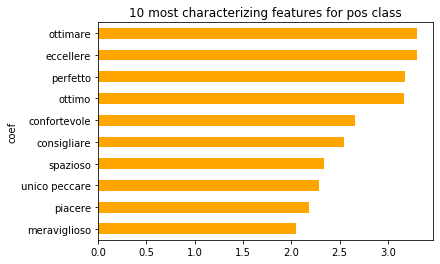

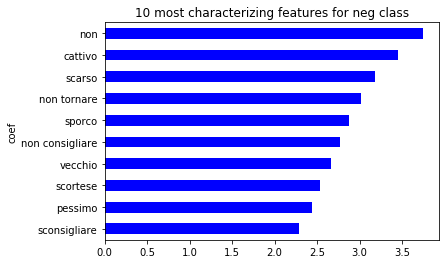

In [981]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    neg = []
    pos = []
    nf = []
    pf = []
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        neg.append(abs(coef_1))
        nf.append(fn_1)
        pos.append(coef_2)
        pf.append(fn_2)
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
    return neg, nf, pos, pf
        
neg, nf, pos, pf = show_most_informative_features(vectorizer, svc)
pd.DataFrame(pos, index=pf).sort_values(0).plot(kind='barh', legend=False, title='10 most characterizing features for pos class', color='orange').set_ylabel("coef")
pd.DataFrame(neg, index=nf).sort_values(0).plot(kind='barh', legend=False, title='10 most characterizing features for neg class', color='blue').set_ylabel("coef")

# Prediction with Linear SVC

In [982]:
from sklearn.svm import LinearSVC
svc = LinearSVC(class_weight='balanced')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Build csv file

In [984]:
#Create csv - c8aeae73dcda4e5dc39aa8f06ab610d18b9c873d031140271c96f9c289db6374
import csv
with open ('C:\\Users\\Administrator\\Desktop\\DATA LAB\\PROJECT_ASSIGNMENT\\dataset_winter_2020\\submit.csv', mode = 'w', newline='') as f:
    w = csv.writer(f, delimiter=',')
    w.writerow(['Id', 'Predicted'])
    for Id, Predicted in enumerate(y_pred):
        w.writerow([Id, Predicted])